In [1]:
import numpy as np
#import project_problems
#import algorithms
#from optSolver_Li_Chenfei import optSolver_Li_Chenfei
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def convert_csv_to_text(csv_file_path, text_file_path):
    # Open the CSV file for reading
    with open(csv_file_path, 'r') as csv_file:
        # Open the text file for writing
        with open(text_file_path, 'w') as text_file:
            # Loop over each line in the CSV file
            for line in csv_file:
                # Split the line into its three components
                parts = line.strip().split(',')
                string_val, int_val, float_val = parts[0], int(parts[1]), float(parts[2])
                
                # Write the three values to the text file
                text_file.write(f'{string_val} {int_val} {float_val}\n')


In [6]:
# Call the function to convert the CSV file "input.csv" to a text file "output.txt"
convert_csv_to_text('BFGSW.csv', 'BFGSW.txt')
convert_csv_to_text('DFP.csv', 'DFP.txt')
convert_csv_to_text('DFPW.csv', 'DFPW.txt')
convert_csv_to_text('GradientDescent.csv', 'GradientDescent.txt')
convert_csv_to_text('GradientDescentW.csv', 'GradientDescentW.txt')
convert_csv_to_text('Newton.csv', 'Newton.txt')
convert_csv_to_text('NewtonW.csv', 'NewtonW.txt')
convert_csv_to_text('TRNewtonCG.csv', 'TRNewtonCG.txt')
convert_csv_to_text('TRSR1CG.csv', 'TRSR1CG.txt')
convert_csv_to_text('BFGS.csv', 'BFGS.txt')


In [7]:
files  = [
  'BFGSW.txt', 'DFP.txt', 'DFPW.txt', 'GradientDescent.txt', 'GradientDescentW.txt', 'Newton.txt', 'NewtonW.txt', 'TRNewtonCG.txt', 'TRSR1CG.txt',
    'BFGS.txt'
]

algorithms = ['BFGSW', 'DFP', 'DFPW', 'GradientDescent', 'GradientDescentW', 'Newton', 'NewtonW', 'TRNewtonCG', 'TRSR1CG', 'BFGS']

# Determine number of algorithms
num_algorithms = len(algorithms)

# Check that number of files == number of algorithms
if len(files) != num_algorithms:
    raise ValueError('profilerDolanMore: Number of file names not equal to the number of algorithm names provided.\n')
    
# Open files
f_in = [None]*num_algorithms
for i in range(num_algorithms):
    f_in[i] = open(files[i], 'r')
    if f_in[i] == -1:
        raise IOError('profilerDolanMore: Could not open input file: %s\n' % files[i])
        
## File format per line
file_format = '%s %d %f'

# Read raw data
raw_data = [None]*num_algorithms
for i in range(num_algorithms):
    f_in[i].seek(0)  # Set file pointer to beginning of file
    raw_data[i] = [tuple(line.strip().split()) for line in f_in[i]]
    raw_data[i] = [(val[0], int(val[1]), float(val[2])) for val in raw_data[i]]
    
# Close data files
for i in range(num_algorithms):
    f_in[i].close()
    
# Confirm that the same number of lines has been read from all files
for i in range(1, num_algorithms):
    if len(raw_data[0]) != len(raw_data[i]):
        msg = 'profilerDynamix: Number of lines read from input file %s differs from number read from input file %s.' % (files[0], files[i])
        raise ValueError(msg)
        
# Set number of problems
num_problems = len(raw_data[0])


# Construct matrix of values for profile
column = 2
data = np.zeros((num_problems, num_algorithms))
for i in range(num_algorithms):
    data[:, i] = [row[column] for row in raw_data[i]]

    
# Check that values are numeric
# Check that values are numeric
if not np.issubdtype(data.dtype, np.number):
    raise ValueError('profilerDolanMore: Performance measures include non-numeric value.')

# Check that values are nonzero
if np.sum(data == 0) > 0:
    raise ValueError('profilerDolanMore: Performance measures include zero value.')

# Set negative values to infinity
data[data < 0] = np.inf




In [8]:
# Construct vector of best values by row
best_by_row = np.min(data, axis=1)

tau_max = 2000
# Construct ratio matrix and determine maximum finite value
ratios = np.zeros((num_problems, num_algorithms))
ratio_max = -1
for i in range(num_problems):
    if best_by_row[i] == np.inf:
        ratios[i, :] = np.inf
    else:
        for j in range(num_algorithms):
            ratios[i, j] = data[i, j] / best_by_row[i]
            if ratios[i, j] < np.inf and ratios[i, j] > ratio_max:
                ratio_max = ratios[i, j]
ratio_max = min(ratio_max, tau_max)

# Sanity check: minimum value for each problem # should be 1 (a success) or inf (all fail)
for i in range(num_problems):
    if (min(ratios[i,:]) != 1) and (min(ratios[i,:]) != float('inf')):
        raise ValueError('profilerDolanMore: Ratio sanity check failed!\n')

# Reshape ratios matrix to determine appropriate increment for plot
ratios_reshaped = ratios.reshape(num_problems*num_algorithms, 1)

# Sort ratios
ratios_sorted = np.sort(ratios_reshaped, axis=None)
# Determine increment
increment = np.inf
for i in range(len(ratios_sorted)-1):
    difference = ratios_sorted[i+1] - ratios_sorted[i]
    if (difference > 0) and (difference < increment):
        increment = difference
       
increment = max(increment, (ratio_max+increment-1)/100)
# Ensure increment is finite
if increment == np.inf:
    raise ValueError('profilerDolanMore: Increment for profile is infinite. Did all algorithms have equal performance?\n')
# Set tau values
tau = np.arange(1, ratio_max+increment, increment)

# Construct matrix of values for plot
profile_values = np.zeros((num_algorithms, len(tau)))
for i in range(num_algorithms):
    for j in range(len(tau)):
        profile_values[i, j] = np.sum(ratios[:, i] <= tau[j]) / num_problems

# Compute area under the curve for each algorithm        
auc = np.zeros(num_algorithms)
for i in range(num_algorithms):
    for j in range(len(tau)-1):
        if tau[j+1] <= ratio_max:
            auc[i] += profile_values[i,j] * (tau[j+1] - tau[j])
        elif tau[j] <= ratio_max:
            auc[i] += profile_values[i,j] * (ratio_max - tau[j])
            
# Print ranking in terms of best measure
ind = np.argsort(profile_values[:,0])[::-1]
print('Best measure ranking:')
for i in range(len(ind)):
    print('{:>20} solved {:5.2f} percent of the problems with the best performance measure'.format(algorithms[ind[i]], 100*profile_values[ind[i],0]))
print()

# Print ranking in terms of reliability
ind = np.argsort(profile_values[:,-1])[::-1]
print('Reliability ranking:')
for i in range(len(ind)):
    print('{:>20} solved {:5.2f} percent of the problems with ratio less than or equal to tau_max = {}'.format(algorithms[ind[i]], 100*profile_values[ind[i],-1], tau_max))
print()

# Print ranking in terms of area under the curve
ind = np.argsort(auc)[::-1]
print('Relative area under the curve ranking:')
for i in range(len(ind)):
    print('{:>20} has area {:e} and relative area (to maximum) {:e}'.format(algorithms[ind[i]], auc[ind[i]], auc[ind[i]]/np.max(auc)))
print()



Best measure ranking:
             TRSR1CG solved 25.00 percent of the problems with the best performance measure
                BFGS solved 16.67 percent of the problems with the best performance measure
             NewtonW solved 16.67 percent of the problems with the best performance measure
    GradientDescentW solved 16.67 percent of the problems with the best performance measure
     GradientDescent solved 16.67 percent of the problems with the best performance measure
          TRNewtonCG solved  8.33 percent of the problems with the best performance measure
              Newton solved  8.33 percent of the problems with the best performance measure
               BFGSW solved  8.33 percent of the problems with the best performance measure
                DFPW solved  0.00 percent of the problems with the best performance measure
                 DFP solved  0.00 percent of the problems with the best performance measure

Reliability ranking:
             TRSR1CG solved 50.00 pe

/var/folders/5p/4b9c5nb91rg07f7s_4jnysdw0000gn/T/ipykernel_8275/628150772.py:31: RuntimeWarning: invalid value encountered in double_scalars
  difference = ratios_sorted[i+1] - ratios_sorted[i]


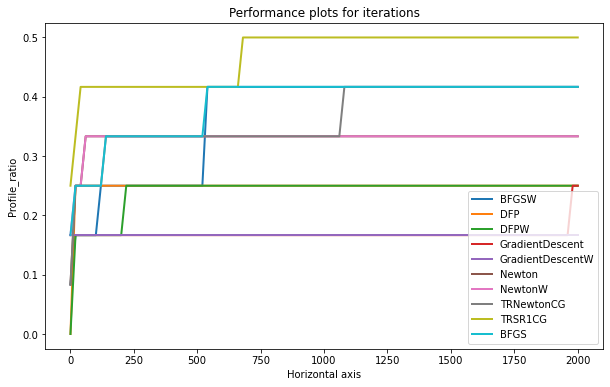

In [9]:
# Plotting
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
#plt.plot(tau, profile_values[0], label=algorithms[0], linewidth=2, drawstyle='default')
for i in range(0, num_algorithms):
    plt.plot(tau, profile_values[i], label=algorithms[i], linewidth=2, drawstyle='default')

plt.legend()
#plt.legend(loc='southeast')
plt.xlabel("Horizontal axis")
plt.ylabel("Profile_ratio")
plt.title ('Performance plots for iterations')
plt.show()